In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(1)

train_X = torch.load("./train_X.pt")
train_Y = torch.load("./train_Y.pt")
valid_X = torch.load("./valid_X.pt")
valid_Y = torch.load("./valid_Y.pt")

train_data = TensorDataset(train_X, train_Y)
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
valid_data = TensorDataset(valid_X, valid_Y)
valid_dataloader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)

In [20]:
from torch import nn

# nn.Moduleを継承してモデルを作成
class Perseptron(nn.Module):
  def __init__(self, input_size, output_size) -> None:
    super().__init__()

    # nn.Linear: 全結合層を作成する
    self.fc = nn.Linear(input_size, output_size, bias=False)

    # 重み行列を正規分布に上書き
    nn.init.normal_(self.fc.weight, 0.0, 1.0)

  def forward(self, x):
    return torch.softmax(self.fc(x), dim=-1)
  
model = Perseptron(train_X.size()[1], 4)
model.load_state_dict(torch.load("./knock73.model.pt"))
loss_fn = nn.CrossEntropyLoss()

In [21]:
from torch import optim

op = optim.SGD(model.parameters(), lr=0.1)

In [22]:
def calc(model, data, label):
  size = len(data)
  pred = model(data)
  loss = loss_fn(pred, label)
  accuracy = (pred.argmax(dim = 1) == label).sum().item() / size

  return loss, accuracy

In [23]:
import matplotlib.pyplot as plt

epochs = 10
losses = torch.zeros((2, epochs))
accuracies = torch.zeros(2, epochs)

for i in range(epochs):
  for j, (data, label) in enumerate(train_dataloader):
    pred = model(data)
    loss = loss_fn(pred, label)

    op.zero_grad()
    loss.backward()
    op.step()
  
  train_loss, train_acc = calc(model, train_X, train_Y)
  valid_loss, valid_acc = calc(model, valid_X, valid_Y)

  losses[0][i] = train_loss
  losses[1][i] = valid_loss

  accuracies[0][i] = train_acc
  accuracies[1][i] = valid_acc

  torch.save(model, f"./checkpoints/model.train.epoch{i}.pt")


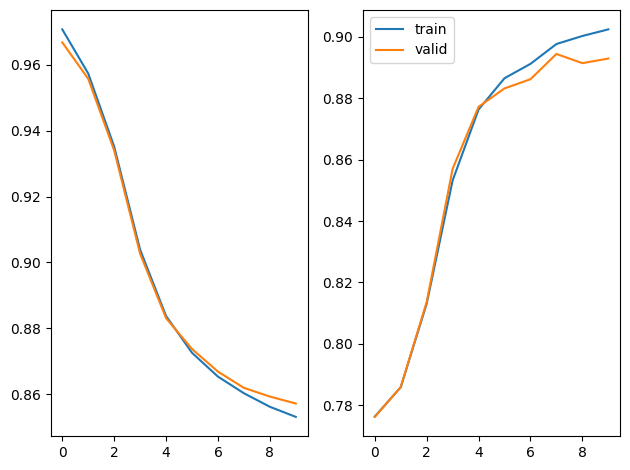

In [24]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(losses[0].detach().numpy(), label="train")
ax[0].plot(losses[1].detach().numpy(), label="valid")
ax[1].plot(accuracies[0].detach().numpy(), label="train")
ax[1].plot(accuracies[1].detach().numpy(), label="valid")

plt.tight_layout()
plt.legend()
plt.show()